<a href="https://colab.research.google.com/github/EgemenGuray/ML-playground/blob/master/MLP_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries & Donwloading Data

We'll be using Keras for building MLP model, pandas for data clearning/processing/maniuplation before training the model, and lastly matplotlib for plotting anyresults and data.

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


To download dataset we'll be using wget command from CLI

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2021-04-05 16:58:33--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.1’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2021-04-05 16:58:34 (17.0 MB/s) - ‘airline-passengers.csv.1’ saved [2180/2180]



#Data Clearning Functions

This Class intilizes with the file name of the dataset. Through its functions can get lag difference, clean, transform, plot, print, load data


In [ ]:
class DataObject():
  def __init__(self, fileName):
    self.dataName = fileName
    self.data = None
    self.diffLookup = {}

  # loads data with the parser funtion stated
  def loadData(self):
    series = read_csv(self.dataName, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=self.parser)
    self.data = series
  
  # convertes date to specified format
  def parser(self, x):
    return datetime.strptime(x, '%Y-%m')

  # plots data
  def plot(self):
    self.data.plot()
    pyplot.show()

  # shows first n entries of  data
  def show(self,n = 10):
    print(self.data.head(n))

  #  returns data as pandas array
  def getData(self):
    return self.data

  # returns data as raw values
  def getRawData(self):
    return self.data.values

  # takes lag difference
  def difference(self, interval=1):
    if interval not in self.diffLookup:
      rawData = self.getRawData()
      res = []
      for i in range(interval, len(rawData)):
        value = rawData[i] - rawData[i - interval]
        res.append(value)
      self.diffLookup[interval] = Series(res)
    
    return self.diffLookup[interval]


In [ ]:
data = DataObject("airline-passengers.csv")
data.loadData()

In [ ]:
data.show()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: Passengers, dtype: int64


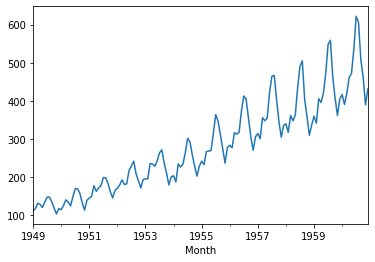

In [ ]:
data.plot()

In [ ]:
data.difference()

0       6
1      14
2      -3
3      -8
4      14
       ..
138   -16
139   -98
140   -47
141   -71
142    42
Length: 143, dtype: int64

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


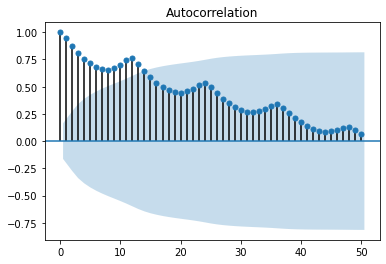

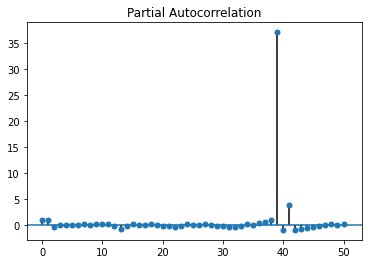

In [ ]:
plot_acf(data.data,lags=50)
plot_pacf(data.data, lags=50)
pyplot.show()

As can be seen terms in data is highly correlated.

# Model Functions

In [ ]:
class ModelObject():

  def __init__(self):
    self.data = None
  
  # loads dataObject
  def loadData(self, dataObject):
    self.data = dataObject

  # modifies given data to comply with input/output patterns.
  # window of previous terms with lag used as input and term as output
  def timeseries_to_supervised(self, data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

  # inverts differenced value
  def inverse_difference(self, history, yhat, interval=1):
	  return yhat + history[-interval]

  # scales train and test data to [-1, 1]
  def scale(self, train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

  # inverses scaling for a forecasted value
  def invert_scale(self, scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

  # fits an MLP network to training data and evaluates performance on test data
  def fit_on_train_eval_on_test(self, train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
      model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
      # evaluate model on train data
      raw_train = raw[-(len(train)+len(test)+1):-len(test)]
      train_rmse.append(self.evaluate(model, raw_train, train, scaler, 0, batch_size))
      # evaluate model on test data
      raw_test = raw[-(len(test)+1):]
      test_rmse.append(self.evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history
  
  # fits an MLP network to training data
  # for activation function we used ReLu, for loss function MSE and for
  # BGD algorithm ADAMs optimizer.
  def fit_model_on_train(self, train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

  # evaluates the model on a dataset, returns RMSE in transformed units
  def evaluate(self, model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
      yhat = output[i,0]
      # invert scaling
      yhat = self.invert_scale(scaler, X[i], yhat)
      # invert differencing
      yhat = yhat + raw_data[i]
      # store forecast
      predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse
    
  # prdicts values of dataset according to saved model and plots both actual and
  # predicted values
  def predictAndPlot(self, lag=3, batch_size=10):
    diff_values = data.difference(1)
    supervised = self.timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    test = supervised_values[:]
    scaler, train_scaled, test_scaled = mlp.scale(train, test)
    test_reshaped = test_scaled[:,0:-1]
    output = self.bestModel.predict(test_reshaped, batch_size)
    predictions = list()
    for i in range(len(output)):
      yhat = output[i,0]
      X = test_scaled[i, 0:-1]
      # invert scaling
      yhat = mlp.invert_scale(scaler, X, yhat)
      # invert differencing
      yhat = mlp.inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
      # store forecast
      predictions.append(yhat)
    # report performance
    self.predictions = predictions
    Series(data=predictions,index=data.data.index[4:]).plot(color='b')
    self.data.data.plot(color='r')
    pyplot.legend(["Predicted", "Actual"])
    pyplot.show()
    return predictions

  def learnAndSave(self, repeats, epochs, lag, neurons, batch_size):
    dataObject = self.data
    # transform data to be stationary
    raw_values = dataObject.getRawData()
    diff_values = dataObject.difference(1)
    # transform data to be supervised learning
    supervised = self.timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = self.scale(train, test)
    # run experiment
    min_error = float('inf')
    for r in range(repeats):
      # fit the model
      train_trimmed = train_scaled[2:, :]
      model = self.fit_model_on_train(train_trimmed, batch_size, epochs, neurons)
      # forecast test dataset
      test_reshaped = test_scaled[:,0:-1]
      output = model.predict(test_reshaped, batch_size=batch_size)
      predictions = list()
      for i in range(len(output)):
        yhat = output[i,0]
        X = test_scaled[i, 0:-1]
        # invert scaling
        yhat = self.invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = self.inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
      # report performance
      rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
      
      if rmse < min_error:
        min_error = rmse
        self.bestModel = model
        print('%d) Test RMSE: %.3f New Best Model' % (r+1, rmse))
      else:
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
    

  # runs a repeated experiment for determingin bet paraemetrs for epochs, run , lag
  def experiment(self, repeats, epochs, lag, neurons, batch_size = 4):
    dataObject = self.data
    # transform data to be stationary
    raw_values = dataObject.getRawData()
    diff_values = dataObject.difference(1)
    # transform data to be supervised learning
    supervised = self.timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = self.scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
      # fit the model
      train_trimmed = train_scaled[2:, :]
      model = self.fit_model_on_train(train_trimmed, batch_size, epochs, neurons)
      # forecast test dataset
      test_reshaped = test_scaled[:,0:-1]
      output = model.predict(test_reshaped, batch_size=batch_size)
      predictions = list()
      for i in range(len(output)):
        yhat = output[i,0]
        X = test_scaled[i, 0:-1]
        # invert scaling
        yhat = self.invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = self.inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
      # report performance
      rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
      print('%d) Test RMSE: %.3f' % (r+1, rmse))
      error_scores.append(rmse)
    return error_scores

  # run diagnostic experiments
  def run(self, repeats, n_batch, n_epoch, n_neurons, n_lag):
    # load dataset
    dataObject = self.data
    # transform data to be stationary
    raw_values = dataObject.getRawData()
    diff_values = dataObject.difference(1)
    # transform data to be supervised learning
    supervised = self.timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = self.scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
      history = self.fit_on_train_eval_on_test(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
      pyplot.plot(history['train'], color='blue')
      pyplot.plot(history['test'], color='orange')
      print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))




In [ ]:
mlp = ModelObject()
mlp.loadData(data)

In order to show the process of choosing hyperparameters such as lag, # of epochs, batch size, # of neurons in hidden layer hyperparameter algortihms will not be used to do it automatically. Manual optimization with MC simulations with different parameter selections will be used to select best parameters. 

# Epoch Config

1) Test RMSE: 53.932
2) Test RMSE: 52.741
3) Test RMSE: 54.870
4) Test RMSE: 50.268
5) Test RMSE: 50.719
6) Test RMSE: 53.029
7) Test RMSE: 59.117
8) Test RMSE: 52.775
9) Test RMSE: 53.081
10) Test RMSE: 52.960
11) Test RMSE: 50.094
12) Test RMSE: 52.729
13) Test RMSE: 53.719
14) Test RMSE: 50.587
15) Test RMSE: 54.217
16) Test RMSE: 53.834
17) Test RMSE: 50.157
18) Test RMSE: 52.820
19) Test RMSE: 52.836
20) Test RMSE: 53.088
21) Test RMSE: 50.225
22) Test RMSE: 50.935
23) Test RMSE: 53.104
24) Test RMSE: 53.104
25) Test RMSE: 50.696
26) Test RMSE: 56.631
27) Test RMSE: 50.274
28) Test RMSE: 52.830
29) Test RMSE: 51.857
30) Test RMSE: 52.626
1) Test RMSE: 53.492
2) Test RMSE: 52.789
3) Test RMSE: 53.104
4) Test RMSE: 50.091
5) Test RMSE: 53.080
6) Test RMSE: 50.130
7) Test RMSE: 52.621
8) Test RMSE: 52.795
9) Test RMSE: 53.137
10) Test RMSE: 50.195
11) Test RMSE: 53.235
12) Test RMSE: 53.034
13) Test RMSE: 52.791
14) Test RMSE: 52.582
15) Test RMSE: 52.790
16) Test RMSE: 50.088
17) Te

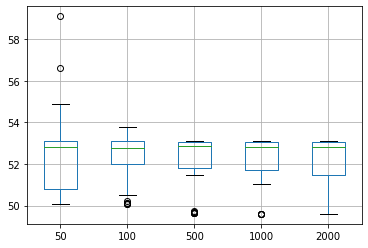

In [ ]:
# experiment
repeats = 30
results = DataFrame()
lag = 1
neurons = 1
# vary training epochs
epochs = [50, 100, 500, 1000, 2000]
for e in epochs:
	results[str(e)] = mlp.experiment(repeats, e, lag, neurons)
# summarize results
print(results.describe())
results.boxplot()

0) TrainRMSE=31.593974, TestRMSE=52.946914
1) TrainRMSE=31.593974, TestRMSE=53.103916
2) TrainRMSE=31.593974, TestRMSE=53.023823
3) TrainRMSE=29.775178, TestRMSE=52.796614
4) TrainRMSE=29.775251, TestRMSE=52.780268
5) TrainRMSE=31.593974, TestRMSE=53.103916
6) TrainRMSE=29.775014, TestRMSE=52.793832
7) TrainRMSE=30.248515, TestRMSE=49.597479
8) TrainRMSE=31.003703, TestRMSE=51.470989
9) TrainRMSE=29.775334, TestRMSE=52.795431


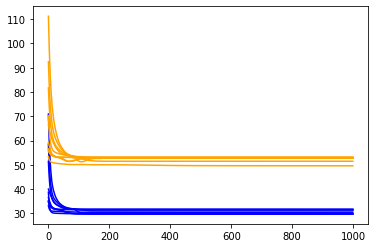

In [ ]:
# config
repeats = 10
n_batch = 4
n_epochs = 1000
n_neurons = 1
n_lag = 1
mlp.run(repeats, n_batch, n_epochs, n_neurons, n_lag)

According to plots 200 epochs is where the model cannot learn any more. However since this test is only with 1 lag and 1 nuerons 1000 epoch is selected due to better results in boxplot to address any model complexity in the future.

# Hidden Layer Config

1) Test RMSE: 53.104
2) Test RMSE: 52.792
3) Test RMSE: 51.472
4) Test RMSE: 53.009
5) Test RMSE: 49.597
6) Test RMSE: 52.778
7) Test RMSE: 49.600
8) Test RMSE: 51.472
9) Test RMSE: 53.104
10) Test RMSE: 53.104
11) Test RMSE: 52.795
12) Test RMSE: 53.104
13) Test RMSE: 53.104
14) Test RMSE: 52.795
15) Test RMSE: 49.597
16) Test RMSE: 52.797
17) Test RMSE: 53.063
18) Test RMSE: 49.597
19) Test RMSE: 51.471
20) Test RMSE: 52.787
21) Test RMSE: 53.095
22) Test RMSE: 53.104
23) Test RMSE: 51.472
24) Test RMSE: 52.782
25) Test RMSE: 53.104
26) Test RMSE: 52.796
27) Test RMSE: 49.596
28) Test RMSE: 53.104
29) Test RMSE: 52.788
30) Test RMSE: 49.598
1) Test RMSE: 51.686
2) Test RMSE: 53.626
3) Test RMSE: 51.840
4) Test RMSE: 53.104
5) Test RMSE: 51.677
6) Test RMSE: 51.680
7) Test RMSE: 50.054
8) Test RMSE: 51.918
9) Test RMSE: 51.832
10) Test RMSE: 52.767
11) Test RMSE: 52.796
12) Test RMSE: 51.600
13) Test RMSE: 53.066
14) Test RMSE: 52.779
15) Test RMSE: 52.780
16) Test RMSE: 51.831
17) Te

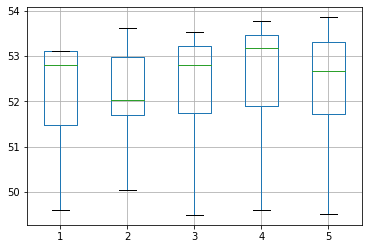

In [ ]:
# experiment
repeats = 30
results = DataFrame()
epochs = 1000
# vary neurons
neurons = [1, 2, 3, 4, 5]
lag = 1
for n in neurons:
	results[str(n)] = mlp.experiment(repeats, epochs, lag, n)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()

0) TrainRMSE=29.650198, TestRMSE=52.016097
1) TrainRMSE=30.999657, TestRMSE=50.214896
2) TrainRMSE=29.474996, TestRMSE=51.842813
3) TrainRMSE=29.676729, TestRMSE=51.730850
4) TrainRMSE=29.666290, TestRMSE=51.811726
5) TrainRMSE=29.712125, TestRMSE=53.579154
6) TrainRMSE=29.765965, TestRMSE=53.148730
7) TrainRMSE=29.663924, TestRMSE=51.688888
8) TrainRMSE=29.775052, TestRMSE=52.907700
9) TrainRMSE=29.775237, TestRMSE=52.762600


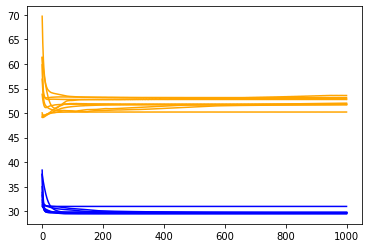

In [ ]:
repeats = 10
n_batch = 4
n_epochs = 1000
n_neurons = 2
n_lag = 1
mlp.run(repeats, n_batch, n_epochs, n_neurons, n_lag)

According to boxplot 2 neurons in hidden layer gives the best result with lag 1

# Lag with Hidden Layer Config

1) Test RMSE: 49.598
2) Test RMSE: 52.795
3) Test RMSE: 52.793
4) Test RMSE: 53.052
5) Test RMSE: 53.104
6) Test RMSE: 49.598
7) Test RMSE: 52.787
8) Test RMSE: 53.104
9) Test RMSE: 51.471
10) Test RMSE: 53.036
11) Test RMSE: 52.796
12) Test RMSE: 49.598
13) Test RMSE: 53.104
14) Test RMSE: 51.471
15) Test RMSE: 52.796
16) Test RMSE: 52.798
17) Test RMSE: 53.104
18) Test RMSE: 53.104
19) Test RMSE: 52.783
20) Test RMSE: 52.793
21) Test RMSE: 52.792
22) Test RMSE: 52.927
23) Test RMSE: 52.789
24) Test RMSE: 53.104
25) Test RMSE: 52.786
26) Test RMSE: 49.597
27) Test RMSE: 52.793
28) Test RMSE: 53.088
29) Test RMSE: 49.599
30) Test RMSE: 52.793
1) Test RMSE: 47.971
2) Test RMSE: 46.328
3) Test RMSE: 48.387
4) Test RMSE: 43.247
5) Test RMSE: 50.713
6) Test RMSE: 43.178
7) Test RMSE: 47.031
8) Test RMSE: 47.921
9) Test RMSE: 53.180
10) Test RMSE: 41.825
11) Test RMSE: 40.254
12) Test RMSE: 46.893
13) Test RMSE: 48.608
14) Test RMSE: 47.970
15) Test RMSE: 47.100
16) Test RMSE: 49.612
17) Te

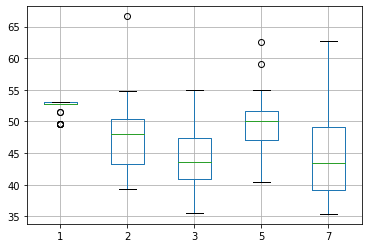

In [ ]:
repeats = 30
results = DataFrame()
epochs = 1000
# vary neurons
neurons = [1, 2, 3, 5, 7]
for n in neurons:
	results[str(n)] = mlp.experiment(repeats, epochs, n, n, batch_size=4)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()

0) TrainRMSE=23.061712, TestRMSE=38.314500
1) TrainRMSE=25.445301, TestRMSE=40.164447
2) TrainRMSE=26.316095, TestRMSE=45.912946
3) TrainRMSE=30.495606, TestRMSE=48.146367
4) TrainRMSE=23.673634, TestRMSE=35.583462
5) TrainRMSE=26.830010, TestRMSE=44.093684
6) TrainRMSE=27.789479, TestRMSE=42.096568
7) TrainRMSE=25.922474, TestRMSE=44.237089
8) TrainRMSE=25.480021, TestRMSE=39.920060
9) TrainRMSE=22.654259, TestRMSE=51.548936


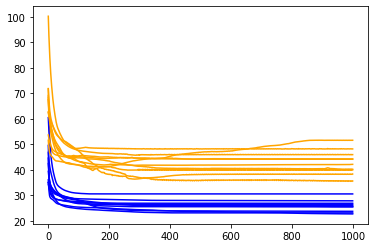

In [ ]:
repeats = 10
n_batch = 4
n_epochs = 1000
n_neurons = 3
n_lag = 3
mlp.run(repeats, n_batch, n_epochs, n_neurons, n_lag)

According to boxplot 3 neurons with 3 lags gives the best results. Comapred to 2 neurons with 1 lag 3/3 selection is better. So 3 nuerons in hidden layer with lag 3 will be used.

# Batch Size Config

1) Test RMSE: 44.241
2) Test RMSE: 53.849
3) Test RMSE: 45.506
4) Test RMSE: 39.993
5) Test RMSE: 53.436
6) Test RMSE: 45.767
7) Test RMSE: 47.814
8) Test RMSE: 43.294
9) Test RMSE: 37.400
10) Test RMSE: 49.275
11) Test RMSE: 42.068
12) Test RMSE: 37.898
13) Test RMSE: 45.997
14) Test RMSE: 44.292
15) Test RMSE: 48.384
16) Test RMSE: 48.896
17) Test RMSE: 37.558
18) Test RMSE: 47.832
19) Test RMSE: 45.113
20) Test RMSE: 33.413
21) Test RMSE: 43.233
22) Test RMSE: 36.353
23) Test RMSE: 48.015
24) Test RMSE: 48.292
25) Test RMSE: 44.524
26) Test RMSE: 43.218
27) Test RMSE: 45.542
28) Test RMSE: 49.259
29) Test RMSE: 47.464
30) Test RMSE: 43.542
1) Test RMSE: 45.025
2) Test RMSE: 38.978
3) Test RMSE: 44.358
4) Test RMSE: 42.696
5) Test RMSE: 36.389
6) Test RMSE: 40.170
7) Test RMSE: 45.030
8) Test RMSE: 47.384
9) Test RMSE: 35.353
10) Test RMSE: 41.110
11) Test RMSE: 38.803
12) Test RMSE: 42.408
13) Test RMSE: 49.649
14) Test RMSE: 39.804
15) Test RMSE: 47.411
16) Test RMSE: 45.134
17) Te

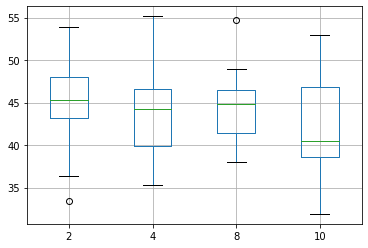

In [ ]:
mlp = ModelObject()
mlp.loadData(data)

repeats = 30
results = DataFrame()
epochs = 1000
# vary neurons
batches = [2, 4, 8, 10]
for b in batches:
	results[str(b)] = mlp.experiment(repeats, epochs,3, 3, batch_size=b)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()

0) TrainRMSE=26.100213, TestRMSE=42.420475
1) TrainRMSE=25.468030, TestRMSE=40.662674
2) TrainRMSE=27.573665, TestRMSE=44.741600
3) TrainRMSE=27.911663, TestRMSE=47.064400
4) TrainRMSE=27.641871, TestRMSE=49.006834
5) TrainRMSE=23.148949, TestRMSE=50.121939
6) TrainRMSE=27.573063, TestRMSE=45.695962
7) TrainRMSE=22.998159, TestRMSE=35.515193
8) TrainRMSE=24.766265, TestRMSE=41.159308
9) TrainRMSE=24.065196, TestRMSE=37.775904


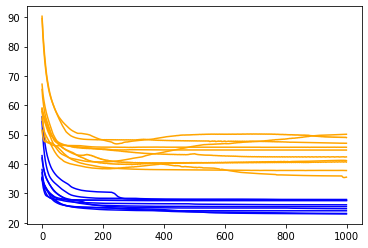

In [ ]:
repeats = 10
n_batch = 10
n_epochs = 1000
n_neurons = 3
n_lag = 3
mlp.run(repeats, n_batch, n_epochs, n_neurons, n_lag)

According to boxplot batch size = 10 gave the best RMSE score. So 10 examples per batch will be used for training

#Best Fit Model

Find best Model based on results of diagnostics. 
Batch Size = 10
Epochs = 1000
Number of Neurons in Hidden Layer = 3
Lag = 3
Will run 10 training with these parameters and will save the model with lowest RMSE score in test data.

In [ ]:
mlp.learnAndSave(10,1000,3,3,10)

1) Test RMSE: 52.947 New Best Model
2) Test RMSE: 40.457 New Best Model
3) Test RMSE: 39.901 New Best Model
4) Test RMSE: 37.431 New Best Model
5) Test RMSE: 48.738
6) Test RMSE: 51.000
7) Test RMSE: 47.219
8) Test RMSE: 40.904
9) Test RMSE: 35.961 New Best Model
10) Test RMSE: 38.217


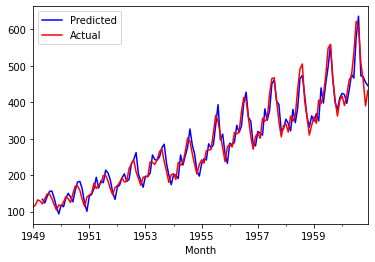

In [ ]:
predicted = mlp.predictAndPlot()
res = data.data.values[4:] - numpy.array(predicted)

Seems like best fitted model predicted values pretty close to the actual values both plots gives similar results.



#Differences Between Predicted and Actual Values

In [ ]:
res

array([-12.76139364,  11.30958361,   7.25210016,  -7.00641198,
       -20.38540801, -18.15337311,  -8.1984995 ,  24.49250091,
        -3.2980037 ,  12.8615199 ,   4.40048918, -14.97242179,
       -15.23727613,  22.27015521,  12.3311551 , -11.18383434,
       -24.72160029, -28.67638453,  -8.86835073,  39.33999804,
         2.82100121,   3.01924404,  14.931151  , -31.02010691,
         7.4799635 ,  -6.40861279,  19.85412004, -14.51554188,
       -22.04481933, -24.42758105,  -6.67374733,  32.59391366,
         3.92907267,   6.95993181,   0.15834045, -22.36729428,
         0.18669663,  29.79250658,  -1.12917402,  -0.84777328,
       -52.85573098, -11.86999654, -12.46288833,  27.33783395,
        -0.72156269,  -0.14073979,  30.7174102 , -20.33018163,
       -13.54454751,   1.98164308,  14.32574228,  -2.96731097,
       -47.89797556, -21.28463846, -19.57562882,  27.35353997,
         3.35397712, -12.6246838 ,  44.54527638, -28.19458714,
         6.38074022,  11.39714745,  24.9516497 , -33.50

In [150]:
max(abs(res))

68.86648632586002

Maximum difference between predicted and actual values are 68 which is not to high

# Residual Analysis

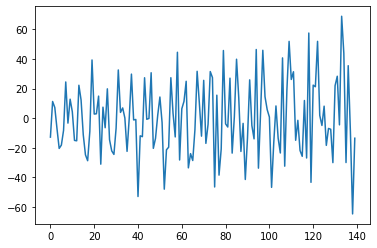

In [ ]:
res_series.plot()
pyplot.show()

In [151]:
sum(res)/len(res)

0.08578815816768579

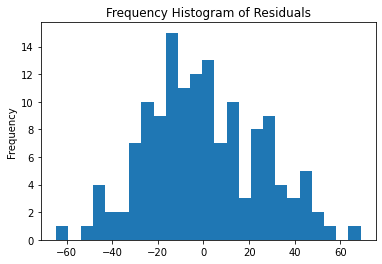

In [164]:
pyplot.hist(res, bins=25)
pyplot.gca().set(title='Frequency Histogram of Residuals', ylabel='Frequency');

In [ ]:
res_series = Series(res)

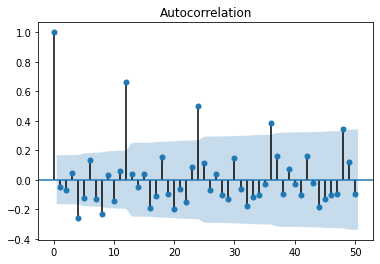

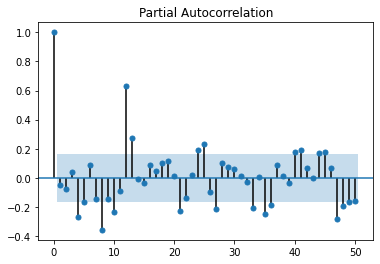

In [ ]:
plot_acf(res_series,lags=50)
plot_pacf(res_series, lags=50)
pyplot.show()

According to the distirubtion residuals resembles a Normal distrubtion with mean 0. And the plot of residuls suggest that it's almost like a white noise.
When we look at the ACF and PACF plots, we can see that there is still some correlation in residuals which couldn't be captured by the model. 

This may be addressed by different variety of hidden layers and lag configrations, especially addressing the seasonailty correlation of the data.